Se importan las librearias necesarias

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

Se Define la función base phi_j(x)

In [1]:
# Definir la función base phi_j(x)
def phi_j(x, j):
    if j == 0:
        return np.ones_like(x)
    elif j % 2 == 1:  # j impar
        return np.cos(np.pi * j * x)
    else:  # j par
        return np.sin(np.pi * j * x)

In [2]:
# Construir la matriz de diseño
def design_matrix(x, max_j):
    X = np.column_stack([phi_j(x, j) for j in range(max_j + 1)])
    return X

In [371]:
# Función para ajustar el modelo usando mínimos cuadrados
""" def fit_model(X, y):
    return np.linalg.lstsq(X, y, rcond=None)[0] """

' def fit_model(X, y):\n    return np.linalg.lstsq(X, y, rcond=None)[0] '

In [3]:
# Función para ajustar el modelo usando mínimos cuadrados de forma matricial
def fit_model(X, y):
    # Calcular la pseudo-inversa de X
    XTX_inv = np.linalg.inv(X.T @ X)
    XTy = X.T @ y
    theta = XTX_inv @ XTy
    return theta

In [4]:
# Función para predecir usando el modelo ajustado
def predict_model(X, theta):
    return X @ theta

In [32]:
# Algoritmo RANSAC
def ransac(x, y, max_j, K, n, T):
    best_theta = None
    max_inliers = 0

    for k in range(K):
        # Seleccionar aleatoriamente n puntos
        indices = np.random.choice(len(x), n, replace=True)
        X_sample = design_matrix(x[indices], max_j)
        y_sample = y[indices]

        # Ajustar el modelo a estos puntos
        theta = fit_model(X_sample, y_sample)

        # Contar el número de inliers
        inlier_count = 0
        X_full = design_matrix(x, max_j)
        y_pred = predict_model(X_full, theta)
        residuals = np.abs(y - y_pred)
        
        for i in range(len(y)):
            if residuals[i] < T:
                inlier_count += 1

        # Actualizar el mejor modelo si es necesario
        if inlier_count > max_inliers:
            max_inliers = inlier_count
            best_theta = theta

    return best_theta

In [45]:
# Generar datos sintéticos con características periódicas
np.random.seed(0)
x = np.linspace(0, 1, 100)
y_true = 2 * np.sin(4 * np.pi * x) + 0.5 * np.cos(8 * np.pi * x)

# Introducir ruido
y_noisy = y_true + np.random.normal(0, 0.5, len(x*10))

# Introducir valores atípicos
n_outliers = 50
outlier_indices = np.random.choice(len(x), n_outliers, replace=True)
y_noisy[outlier_indices] += np.random.normal(0, 2, n_outliers)

In [46]:
# Parámetros del algoritmo RANSAC
K = 1000  # Número de iteraciones
n = 500    # Número de puntos de muestra
T = 0.5   # Umbral de inliers
max_j = 4 # Número de términos de Fourier

# Ejecutar RANSAC
best_theta_ransac = ransac(x, y_noisy, max_j, K, n, T)


In [47]:
# Ajustar el modelo usando mínimos cuadrados ordinarios (OLS)
X_full = design_matrix(x, max_j)
(x, max_j)
theta_ols = fit_model(X_full, y_noisy)

In [48]:
# Predecir usando ambos modelos
y_ransac_pred = predict_model(X_full, best_theta_ransac)
y_ols_pred = predict_model(X_full, theta_ols)

In [49]:
# Calcular MSE y RMSE
mse_ransac = mean_squared_error(y_true, y_ransac_pred)
rmse_ransac = np.sqrt(mse_ransac)
mse_ols = mean_squared_error(y_true, y_ols_pred)
rmse_ols = np.sqrt(mse_ols)

# Imprimir los resultados
print(f'RANSAC MSE: {mse_ransac}, RMSE: {rmse_ransac}')
print(f'OLS MSE: {mse_ols}, RMSE: {rmse_ols}')

RANSAC MSE: 0.16026475450547198, RMSE: 0.4003308063407961
OLS MSE: 0.20846175135350406, RMSE: 0.456576117808963


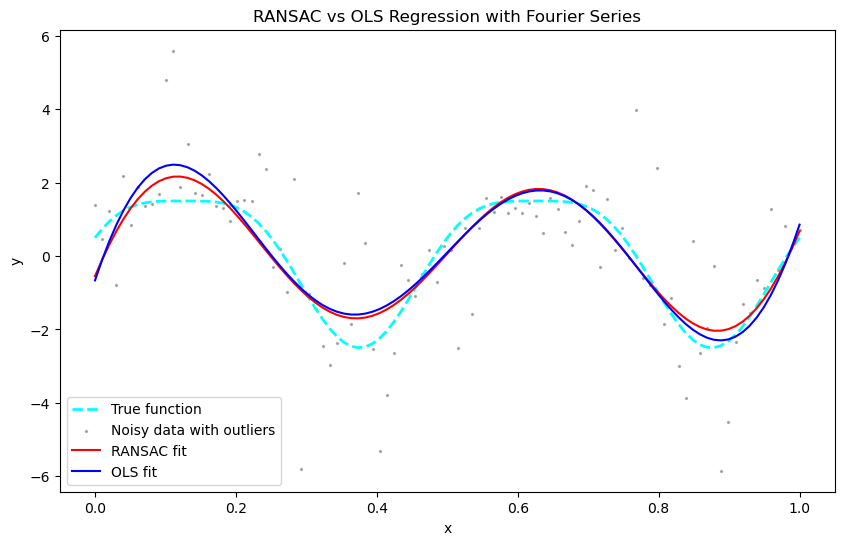

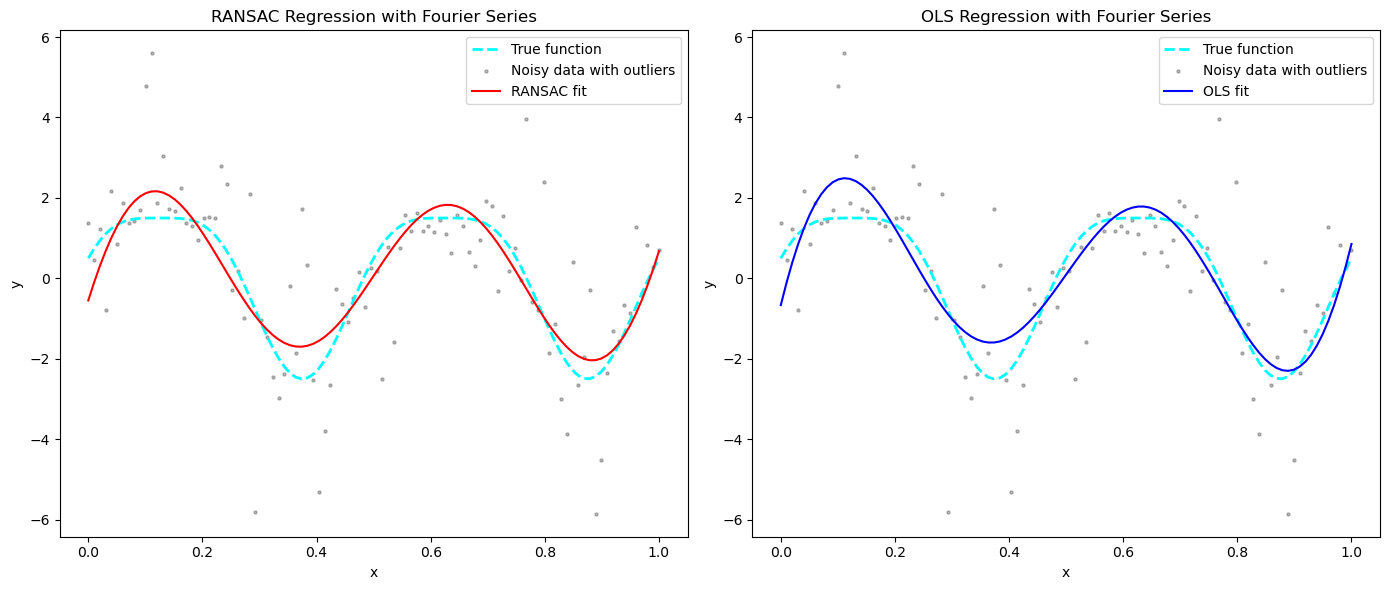

In [50]:
# Visualizar los resultados
plt.figure(figsize=(10, 6))
plt.plot(x, y_true, label='True function', linestyle='--', linewidth=2, color='cyan')
plt.scatter(x, y_noisy, color='black', label='Noisy data with outliers', alpha=0.25, s=2)
plt.plot(x, y_ransac_pred, label='RANSAC fit', color='red')
plt.plot(x, y_ols_pred, label='OLS fit', color='blue')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('RANSAC vs OLS Regression with Fourier Series')
plt.show()

# Generar la figura
plt.figure(figsize=(14, 6))

# Subplot para RANSAC
plt.subplot(1, 2, 1)
plt.plot(x, y_true, label='True function', linestyle='--', linewidth=2, color='cyan')
plt.scatter(x, y_noisy, color='black', label='Noisy data with outliers',alpha=0.25, s=5)
plt.plot(x, y_ransac_pred, label='RANSAC fit', color='red')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('RANSAC Regression with Fourier Series')

# Subplot para OLS
plt.subplot(1, 2, 2)
plt.plot(x, y_true, label='True function', linestyle='--', linewidth=2, color='cyan')
plt.scatter(x, y_noisy, color='black', label='Noisy data with outliers',alpha=0.25, s=5)
plt.plot(x, y_ols_pred, label='OLS fit', color='blue')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('OLS Regression with Fourier Series')

plt.tight_layout()
plt.show()

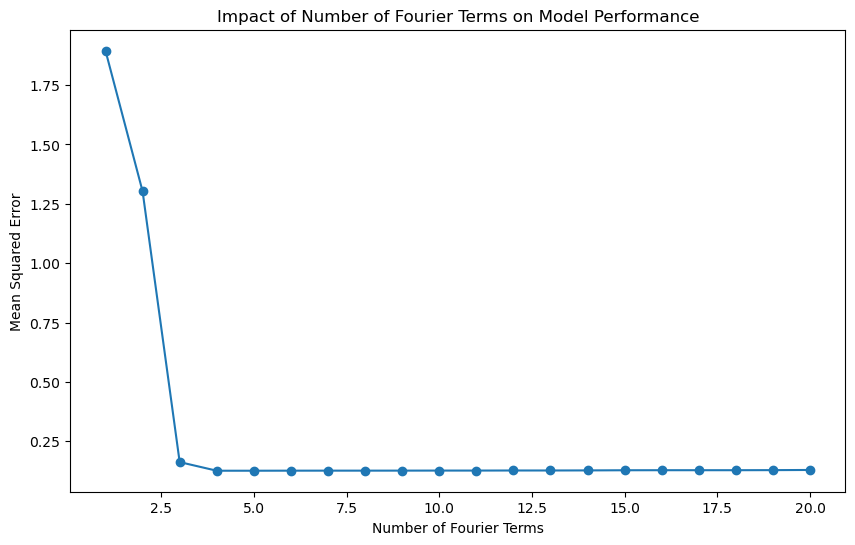

Optimal number of Fourier terms: 4


In [381]:
# Ajustar el modelo y analizar el rendimiento
max_terms = 20
errors = []

for max_j in range(1, max_terms + 1):
    X = design_matrix(x, max_j)
    model = LinearRegression()
    model.fit(X, y_noisy)
    y_pred = model.predict(X)
    mse = mean_squared_error(y_true, y_pred)
    errors.append(mse)

# Visualizar el error en función del número de términos de Fourier
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_terms + 1), errors, marker='o')
plt.xlabel('Number of Fourier Terms')
plt.ylabel('Mean Squared Error')
plt.title('Impact of Number of Fourier Terms on Model Performance')
plt.show()

# Seleccionar un número apropiado de términos basado en el análisis
optimal_terms = np.argmin(errors) + 1
print(f'Optimal number of Fourier terms: {optimal_terms}')